In [1]:
from py_experimenter.experimenter import PyExperimenter
import zlib
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import pickle

In [2]:
job_type = "classification"
experimenter = PyExperimenter(
            experiment_configuration_file_path=f"config/experiments-fullforests-{job_type}.cfg",
            use_codecarbon=False
        )

2023-10-04 20:11:05,839  | py-experimenter - INFO     | Initialized and connected to database


In [3]:
df = experimenter.get_table()

In [4]:
df = df[df["scores"].notna()]

In [5]:
df

,ID,openmlid,seed,eps,zfactor,creation_date,status,start_date,name,machine,scores,end_date,error
0,1,3,0,0.005,2.0,2023-10-03 21:57:28,done,2023-10-03 21:57:31,lappy,frank,"[[[""f"", ""f"", ""f"", ""f"", ""f"", ""f"", ""f"", ""f"", ""f""...",2023-10-03 21:57:34,None
1,2,14,0,0.005,2.0,2023-10-03 21:57:28,done,2023-10-03 21:57:34,lappy,frank,"[[[0.06588172, 0.19731169, 0.10382563, 0.27036...",2023-10-03 21:57:46,None
2,3,16,0,0.005,2.0,2023-10-03 21:57:28,done,2023-10-03 21:57:46,lappy,frank,"[[[-10.29700756, -11.66678905, 11.56066895, -2...",2023-10-03 21:58:00,None
3,4,18,0,0.005,2.0,2023-10-03 21:57:28,done,2023-10-03 21:58:00,lappy,frank,"[[[1.0, 0.0, 0.0, 133.1508614, 1.31169276, 162...",2023-10-03 21:58:07,None
4,5,21,0,0.005,2.0,2023-10-03 21:57:28,done,2023-10-03 21:58:08,lappy,frank,"[[[""vhigh"", ""vhigh"", ""2"", ""2"", ""small"", ""low""]...",2023-10-03 21:58:16,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,77,849,0,0.005,2.0,2023-10-03 21:57:28,done,2023-10-03 23:23:03,lappy,frank,"[[[0.843376, 1.128392, -1.684857, 1.017291, 0....",2023-10-03 23:23:07,None
77,78,866,0,0.005,2.0,2023-10-03 21:57:28,done,2023-10-03 23:23:07,lappy,frank,"[[[0.394484, 0.228851, 0.819326, 0.736256, 1.1...",2023-10-03 23:23:14,None
78,79,871,0,0.005,2.0,2023-10-03 21:57:28,done,2023-10-03 23:23:14,lappy,frank,"[[[-2.3482, 3.6314, 5.0289, 10.8721, -1.3852],...",2023-10-03 23:23:18,None
79,80,881,0,0.005,2.0,2023-10-03 21:57:28,done,2023-10-03 23:23:18,lappy,frank,"[[[3.50591, -13.114, ""brown"", -6.55701, 0.0188...",2023-10-03 23:23:31,None


In [6]:
from utils_ import *

In [7]:
for openmlid in tqdm(pd.unique(df["openmlid"])):
    seed = 0
    if int(openmlid) <= 10 and not is_analyzer_serialized(openmlid, seed):
        print(openmlid)
        row = df[df["openmlid"] == openmlid].iloc[0]
        write_analyzer_to_disk(get_analyzer_from_row(row), 0)

  0%|                                                                                                                                                                  | 0/76 [00:00<?, ?it/s]

3



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 340/340 [00:00<00:00, 471.49it/s]

  0%|                                                                                                                                                                  | 0/76 [00:02<?, ?it/s]


TypeError: write_analyzer_to_disk() takes 1 positional argument but 2 were given

In [9]:


eps_base = 0.01
for openmlid in pd.unique(df["openmlid"]):
    seed = 0
    if not is_analyzer_serialized(openmlid, seed):
        continue
    print(openmlid)
    analyzer = get_analyzer_from_disk(openmlid, seed)
    times = np.arange(1, 21)
    alpha_eps_combos = list(zip([0.5, 0.6, 0.8, 0.95], [0.8 * eps_base, 0.9 * eps_base, eps_base, 2 * eps_base]))
    offset=2
    alpha = 0.5
    alphas = [alpha]
    for oob in [False, True]:
        for alpha in alphas:
            analyzer.compute_ci_sequence_for_expected_performance_at_size_t_based_on_normality(
                alpha=alpha,
                offset=offset,
                oob=oob
            )
    
    #stopping_points_for_profiles = []
    #for alpha, eps in alpha_eps_combos:
        #stopping_points_for_profiles.append(analyzer.get_stopping_point(alpha=alpha, eps=eps, mode="realistic", min_trees=5, oob=True))
    singular_stopping_point = analyzer.get_stopping_point(alpha=alpha, eps=eps_base, mode="realistic", min_trees=5, oob=True, use_oob_forest_size_estimate_for_correction_term=False)
    #actual_stopping_point = max(stopping_points_for_profiles)
    actual_stopping_point = singular_stopping_point
    if actual_stopping_point is not None and not np.isnan(actual_stopping_point):
        #print(stopping_points_for_profiles, actual_stopping_point, f"Saving compare to singular stopping point: {singular_stopping_point - actual_stopping_point}.")
        val_curve = analyzer.scores_of_forests["val"]
        oob_curve = analyzer.scores_of_forests["oob"]
        val_gap = np.abs(val_curve[actual_stopping_point] - np.mean(val_curve[-10:]))
        oob_gap = np.abs(oob_curve[actual_stopping_point] - np.mean(oob_curve[-10:]))
        print(actual_stopping_point, f"Saving compared to sklearn: {100 - actual_stopping_point}", np.round(oob_gap, 4), np.round(val_gap, 4), max([val_gap, oob_gap]) < eps_base)
        if val_gap > eps_base:
            create_full_belief_plot(analyzer, alpha=alpha, eps=eps_base, decision_oob=True, scoring_oob=False, eps_limit_multiplier=5)
            plt.show()
            plot_estimates_of_correction_term(analyzer)
            plt.show()

            plot_gap_over_time(analyzer,
                alpha=alpha, # deliberately use some higher alpha here.
                oob=True,
                eps = eps_base,
                min_trees=5
            )
            plt.show()

3
24 Saving compared to sklearn: 76 0.008 0.0012 True


/tmp/ipykernel_23214/3681261353.py:126: RuntimeWarning: divide by zero encountered in scalar divide
  ci = stats.norm.interval(alpha, loc=est_mean, scale=est_std/np.sqrt(trees_to_be_considered_for_ci))


14
112 Saving compared to sklearn: -12 0.0095 0.0075 True
16
147 Saving compared to sklearn: -47 0.0095 0.0026 True
18
57 Saving compared to sklearn: 43 0.0173 0.0032 False
21
101 Saving compared to sklearn: -1 0.0077 0.0047 True
22
95 Saving compared to sklearn: 5 0.0081 0.0048 True
23
101 Saving compared to sklearn: -1 0.0089 0.0086 True
24
13 Saving compared to sklearn: 87 0.0006 0.0 True
26


/home/felix/anaconda3/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/felix/anaconda3/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


55 Saving compared to sklearn: 45 0.0083 0.0026 True
28


KeyboardInterrupt: 

In [7]:
eps_base = 0.01
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
datasets = [i for i in pd.unique(df["openmlid"]) if is_analyzer_serialized(i, 0)]
rows = []

pbar = tqdm(total=len(alphas) * len(datasets))
for openmlid in datasets:
    
    # initialize analyzer
    seed = 0
    print(openmlid)
    analyzer = get_analyzer_from_disk(openmlid, seed)
    times = np.arange(1, 21)
    offset=2
    
    # get statistics for 100 trees
    times_fit = np.array(analyzer.times_fit)
    times_overhead = np.array(analyzer.times_predict_train) + np.array(analyzer.times_update)
    val_curve = analyzer.scores_of_forests["val"]
    oob_curve = analyzer.scores_of_forests["oob"]
    val_gap_100 = np.abs(val_curve[100] - np.mean(val_curve[-10:]))
    time_100 = times_fit[:100].sum()
    
    # check regrets for different alphas
    row = [openmlid, val_gap_100, val_gap_100 <= eps_base, time_100]
    for alpha in alphas:
        for oob in [False, True]:
            analyzer.compute_ci_sequence_for_expected_performance_at_size_t_based_on_normality(
                alpha=alpha,
                offset=offset,
                oob=oob
            )

        stopping_point = analyzer.get_stopping_point(alpha=alpha, eps=eps_base, mode="realistic", min_trees=5, oob=True, use_oob_forest_size_estimate_for_correction_term=False)
        if stopping_point is not None and not np.isnan(stopping_point) and stopping_point < len(val_curve):
            val_gap = np.abs(val_curve[stopping_point] - np.mean(val_curve[-10:]))
            oob_gap = np.abs(oob_curve[stopping_point] - np.mean(oob_curve[-10:]))
            time_we = (times_fit[:stopping_point] + times_overhead[:stopping_point]).sum()
            row.extend([stopping_point, oob_gap, val_gap, val_gap <= eps_base, time_we])
        else:
            row.extend([stopping_point, 1, 1, False, np.nan])
        pbar.update(1)
    rows.append(row)
pbar.close()

  0%|                                                                                                                                                                 | 0/836 [00:00<?, ?it/s]/home/felix/Uni/Uni/Sabana/papers/asforests/publications/tmlr 2023/analysis/utils_.py:142: RuntimeWarning: divide by zero encountered in scalar divide
  ci = stats.norm.interval(alpha, loc=est_mean, scale=est_std / np.sqrt(trees_to_be_considered_for_ci))
  0%|▏                                                                                                                                                        | 1/836 [00:00<03:13,  4.31it/s]

3


  1%|██                                                                                                                                                      | 11/836 [00:02<02:36,  5.26it/s]

14


  2%|███▍                                                                                                                                                    | 19/836 [00:08<09:15,  1.47it/s]
KeyboardInterrupt



In [21]:
cols = ["openmlid", f"gap_val_100", "ok_100", "time_100"]
for alpha in alphas:
    cols.extend([f"t_{alpha}", f"oob_val_{alpha}", f"gap_val_{alpha}", f"ok_{alpha}", f"time_asrf_{alpha}"])
df_results = pd.DataFrame(rows, columns=cols).dropna()
df_results

,openmlid,gap_val_100,ok_100,time_100,t_0.1,oob_val_0.1,gap_val_0.1,ok_0.1,time_asrf_0.1,t_0.2,...,t_0.95,oob_val_0.95,gap_val_0.95,ok_0.95,time_asrf_0.95,t_0.99,oob_val_0.99,gap_val_0.99,ok_0.99,time_asrf_0.99
0,3,0.000028,True,1.075290,10,0.026564,0.003181,True,0.113410,10,...,163,0.000887,0.000355,True,1.261446,245.0,0.000161,0.000064,True,1.429247
1,14,0.008659,True,0.354864,54,0.022319,0.010370,False,0.218839,64,...,443,0.001914,0.000908,True,1.276616,695.0,0.000256,0.000311,True,1.919868
2,16,0.002656,True,0.350425,60,0.024309,0.011886,False,0.241864,75,...,595,0.001011,0.000048,True,1.581892,924.0,0.000227,0.000320,True,2.366345
3,18,0.001305,True,0.228633,32,0.029082,0.007564,True,0.091084,37,...,171,0.005952,0.001524,True,0.405789,253.0,0.003043,0.000949,True,0.543736
4,21,0.004755,True,0.123453,32,0.023299,0.010071,False,0.052381,42,...,450,0.001442,0.000141,True,0.547752,726.0,0.001194,0.000169,True,0.853677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,847,0.000063,True,4.163588,22,0.026883,0.012363,False,0.934036,24,...,63,0.006337,0.002326,True,2.672513,93.0,0.002824,0.000176,True,3.949433
71,849,0.001037,True,1.842995,46,0.017522,0.008169,True,0.866567,57,...,820,0.001175,0.001939,True,8.748979,1285.0,0.000337,0.000366,True,13.192319
73,871,0.005117,True,4.140200,49,0.024117,0.006626,True,2.059005,54,...,177,0.001523,0.000786,True,6.506195,256.0,0.000778,0.000236,True,8.870004
74,881,0.000033,True,21.562891,14,0.005315,0.001704,True,10.091204,14,...,18,0.003975,0.000962,True,10.654037,24.0,0.003128,0.000838,True,11.478828


In [22]:
df_results[~df_results["ok_100"]]

,openmlid,gap_val_100,ok_100,time_100,t_0.1,oob_val_0.1,gap_val_0.1,ok_0.1,time_asrf_0.1,t_0.2,...,t_0.95,oob_val_0.95,gap_val_0.95,ok_0.95,time_asrf_0.95,t_0.99,oob_val_0.99,gap_val_0.99,ok_0.99,time_asrf_0.99
13,33,0.010251,False,0.261683,50,0.036001,0.013597,False,0.152471,68,...,760,0.003527,0.001347,True,1.548983,1329.0,0.000391,0.000205,True,2.609653
29,389,0.011233,False,5.013582,64,0.024781,0.017761,False,3.380882,76,...,491,0.002141,0.002142,True,15.065208,802.0,0.000287,0.001839,True,22.836455
31,392,0.011551,False,4.699976,68,0.014509,0.015150,False,3.286415,100,...,1129,0.001127,0.000306,True,27.125152,1932.0,0.000347,0.000224,True,44.370768
32,395,0.011598,False,15.717375,66,0.019707,0.016725,False,10.548633,86,...,862,0.001114,0.002768,True,43.765376,1365.0,0.000898,0.001116,True,62.085882
35,401,0.011059,False,3.388052,80,0.007574,0.017414,False,2.851561,110,...,1122,0.001017,0.001473,True,18.421017,1885.0,0.001520,0.000983,True,29.543531
54,797,0.013040,False,1.690844,60,0.026633,0.008522,True,1.039899,89,...,1294,0.000952,0.000822,True,12.197150,2152.0,0.000836,0.000671,True,19.717527


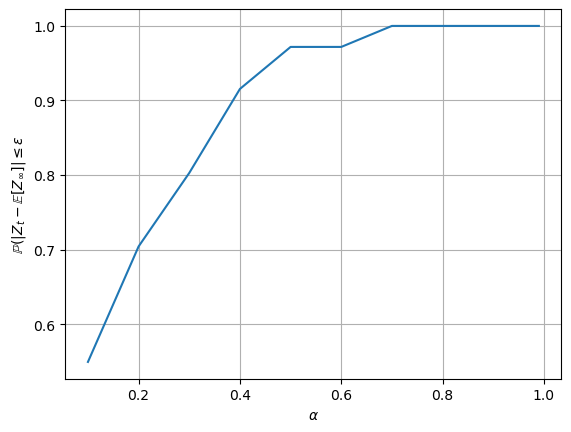

In [23]:
ok_proportion_by_alphas = [df_results[f"ok_{alpha}"].astype(int).mean() for alpha in alphas]
fig, ax = plt.subplots()
ax.plot(alphas, ok_proportion_by_alphas)
ax.grid()
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("$\\mathbb{P}(|Z_t - \\mathbb{E}[Z_\\infty]| \leq \\varepsilon$")
plt.show()

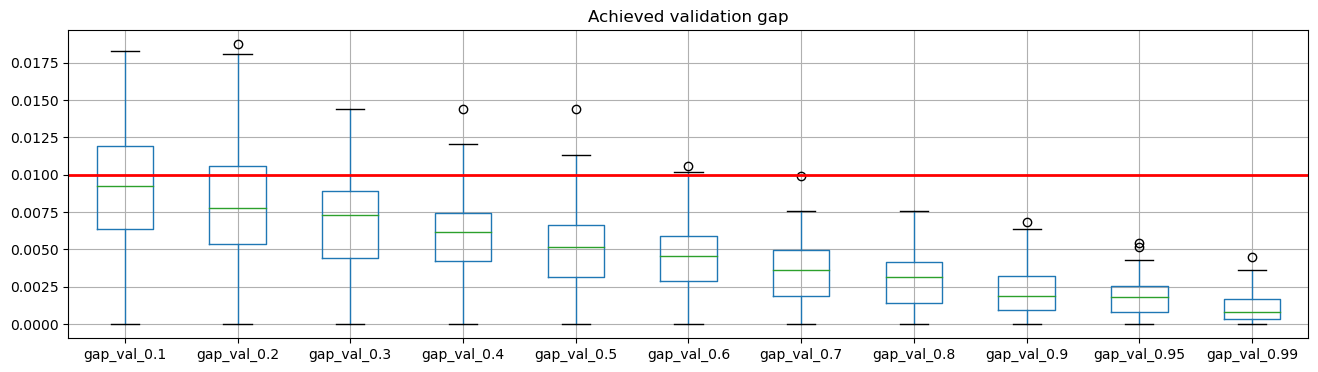

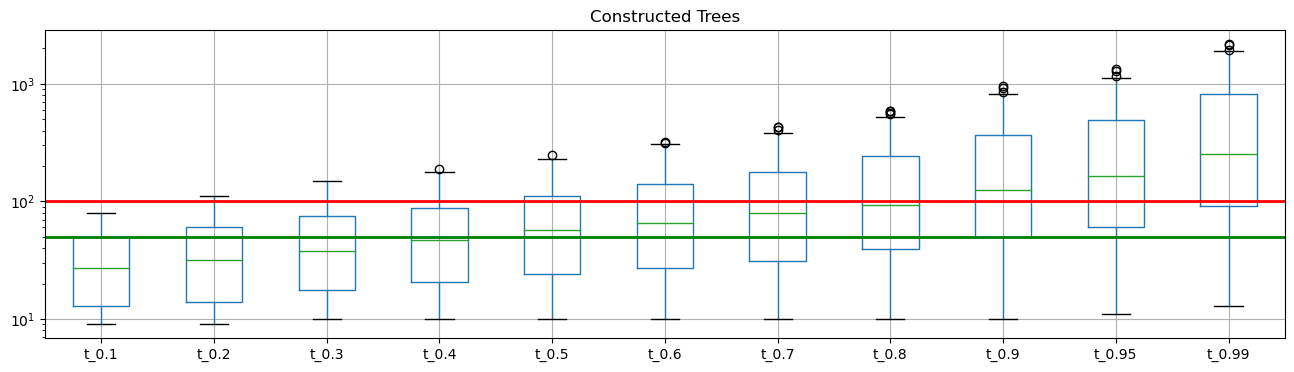

In [24]:
fig, ax = plt.subplots(figsize=(16, 4))
df_results[[c for c in df_results.columns if "gap_val" in c and "100" not in c]].boxplot(ax=ax)
ax.axhline(eps_base, linestyle="-", color="red", linewidth=2)
ax.set_title("Achieved validation gap")
plt.show()

fig, ax = plt.subplots(figsize=(16, 4))
df_results[[c for c in df_results.columns if "t_" in c]].boxplot(ax=ax)
ax.axhline(100, linestyle="-", color="red", linewidth=2)
ax.axhline(50, linestyle="-", color="green", linewidth=2)
ax.set_yscale("log")
ax.set_title("Constructed Trees")
plt.show()

/tmp/ipykernel_138859/3667106430.py:19: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  ax.axhline(-1, color="green", linestyle="--")
/tmp/ipykernel_138859/3667106430.py:20: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  ax.axhline(0, color="gray", linestyle="--")
/tmp/ipykernel_138859/3667106430.py:21: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  ax.axhline(1, color="orange", linestyle="--")


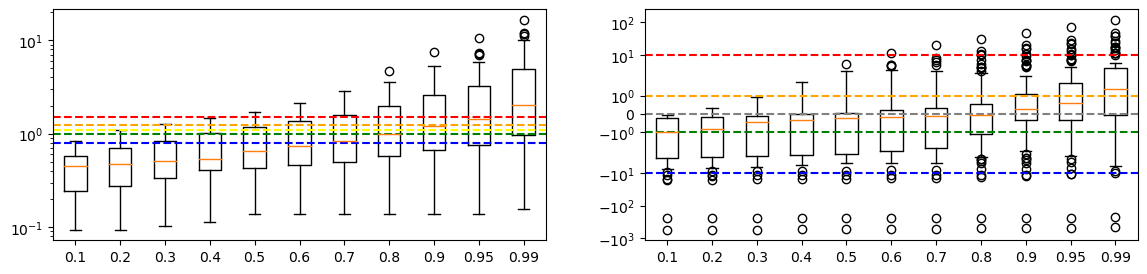

In [38]:
runtimes_asrf = df_results[[c for c in df_results.columns if "time_asrf" in c]].values
runtimes_baseline = df_results["time_100"].values
fig, axs = plt.subplots(1, 2, figsize=(14, 3))
ax = axs[0]
ax.boxplot([row / runtimes_baseline for row in runtimes_asrf.T])
ax.set_xticklabels(alphas)
ax.axhline(0.8, color="blue", linestyle="--")
ax.axhline(1, color="green", linestyle="--")
ax.axhline(1.1, color="yellow", linestyle="--")
ax.axhline(1.25, color="orange", linestyle="--")
ax.axhline(1.5, color="red", linestyle="--")
ax.set_yscale("log")

ax = axs[1]
ax.boxplot([row - runtimes_baseline for row in runtimes_asrf.T])
ax.set_xticklabels(alphas)
ax.set_yscale("symlog")
ax.axhline(-10, color="blue", linestyle="--")
ax.axhline(-1, color="green", linestyle="--")
ax.axhline(0, color="gray", linestyle="--")
ax.axhline(1, color="orange", linestyle="--")
ax.axhline(10, color="red", linestyle="--")

plt.show()

/tmp/ipykernel_138859/4135674790.py:39: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  ax.axhline(0, color="black", linewidth=1)
/tmp/ipykernel_138859/4135674790.py:41: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  ax.axhline(-1, color="green", linestyle="--", alpha=0.4)
/tmp/ipykernel_138859/4135674790.py:42: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  ax.axhline(0, color="gray", linestyle="--", alpha=0.4)
/tmp/ipykernel_138859/4135674790.py:43: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  ax.axhline(1, color="orange", linestyle="--", alpha=0.4)


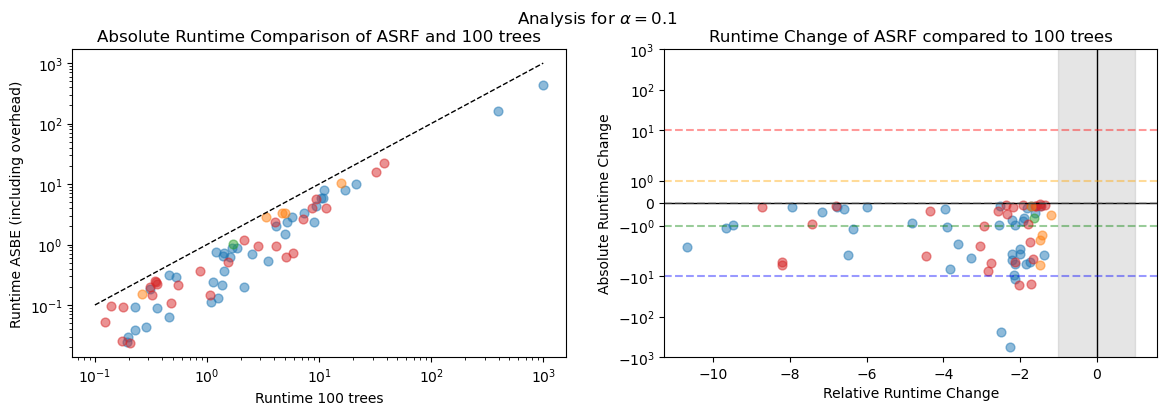

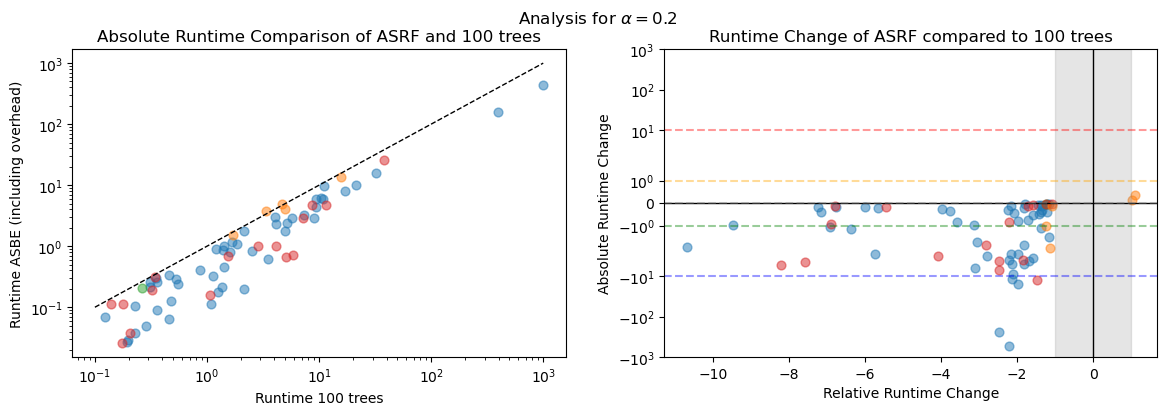

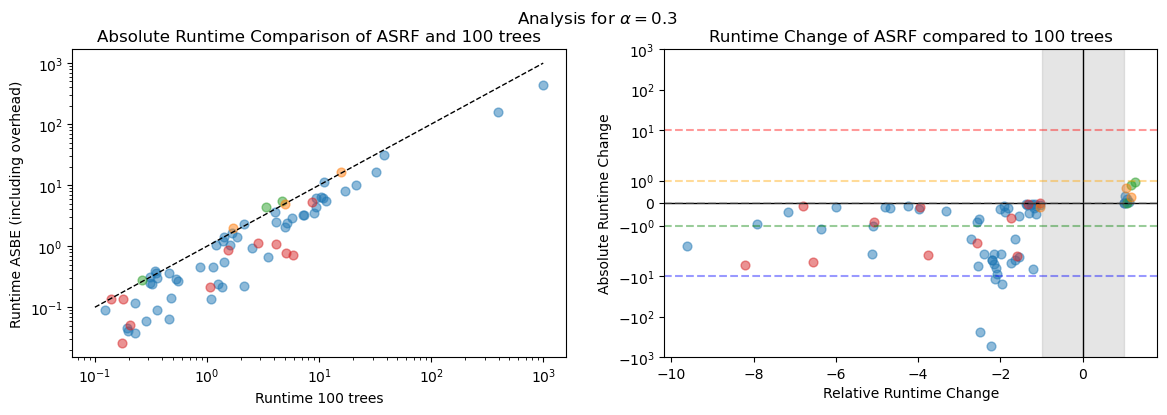

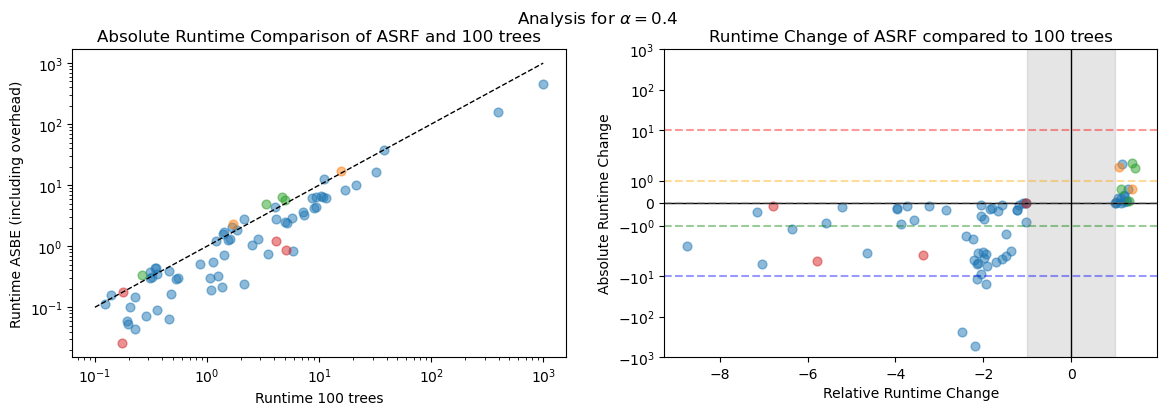

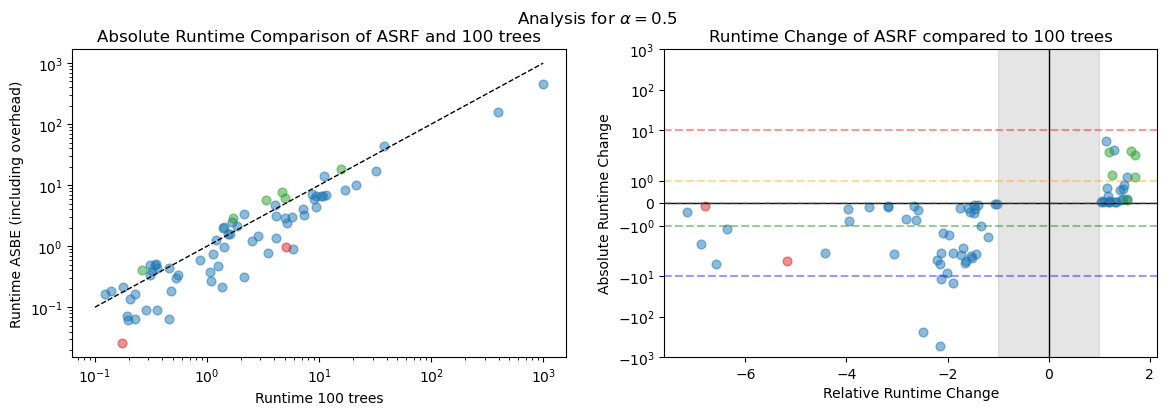

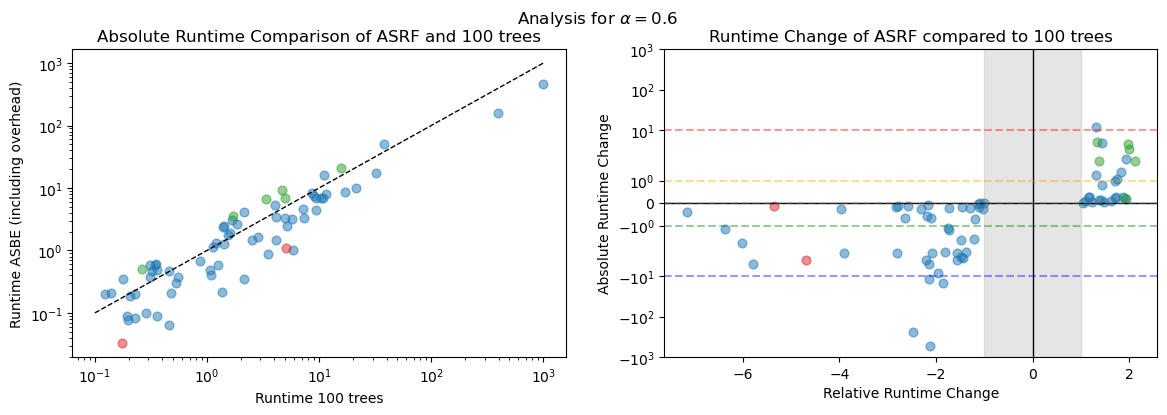

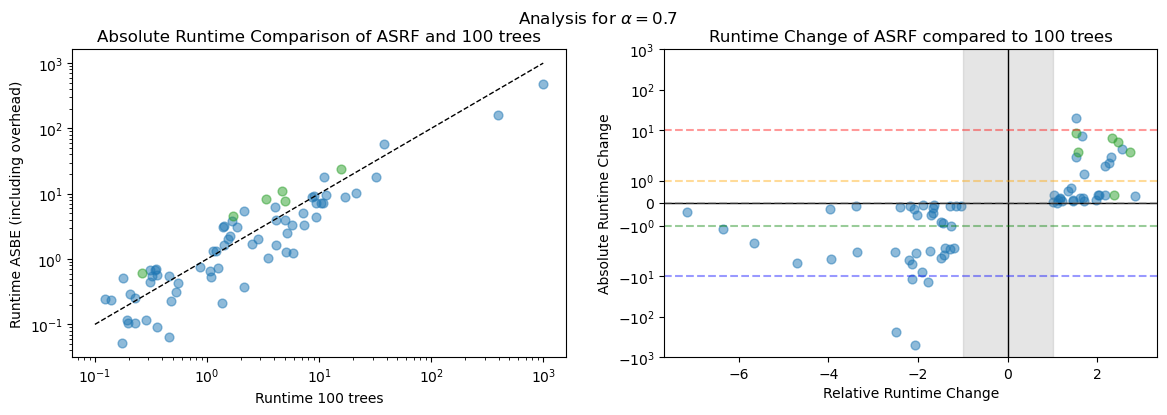

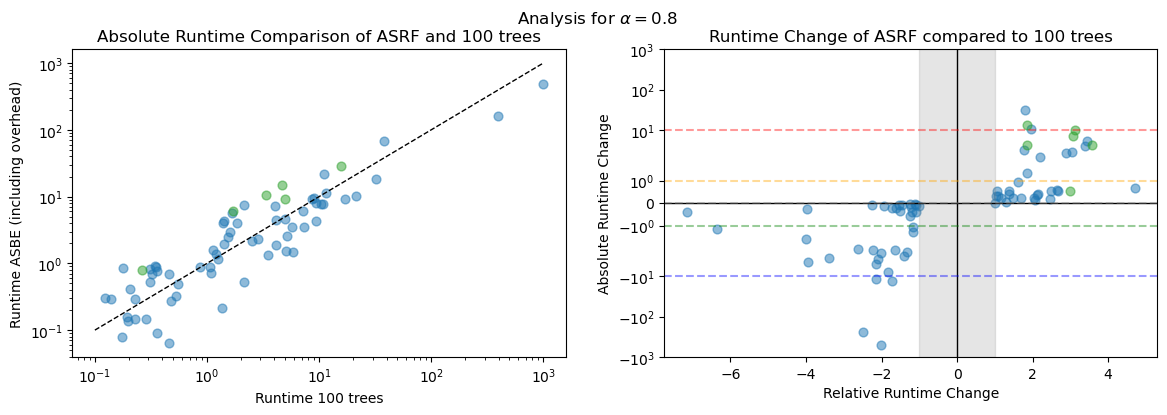

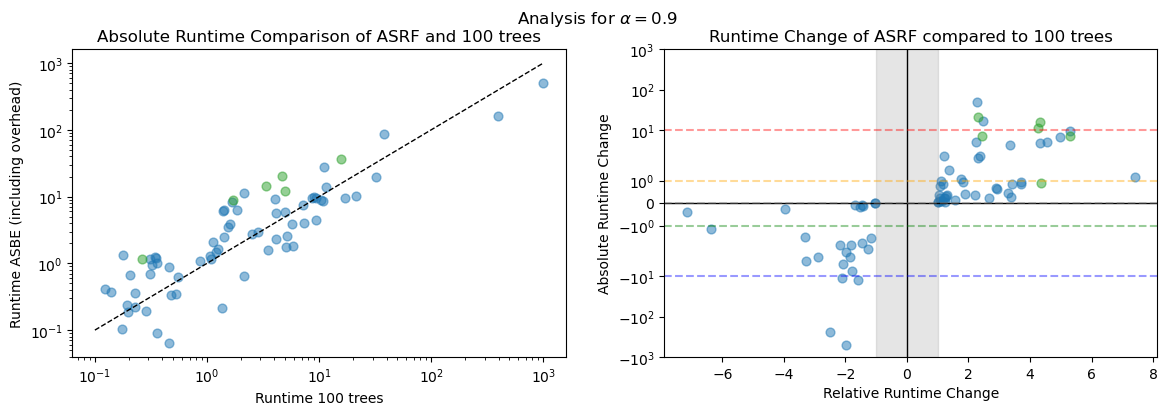

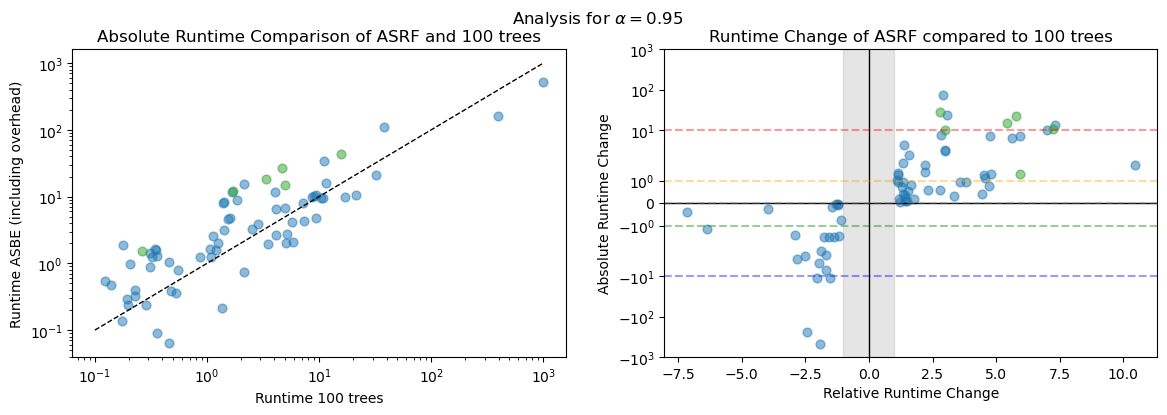

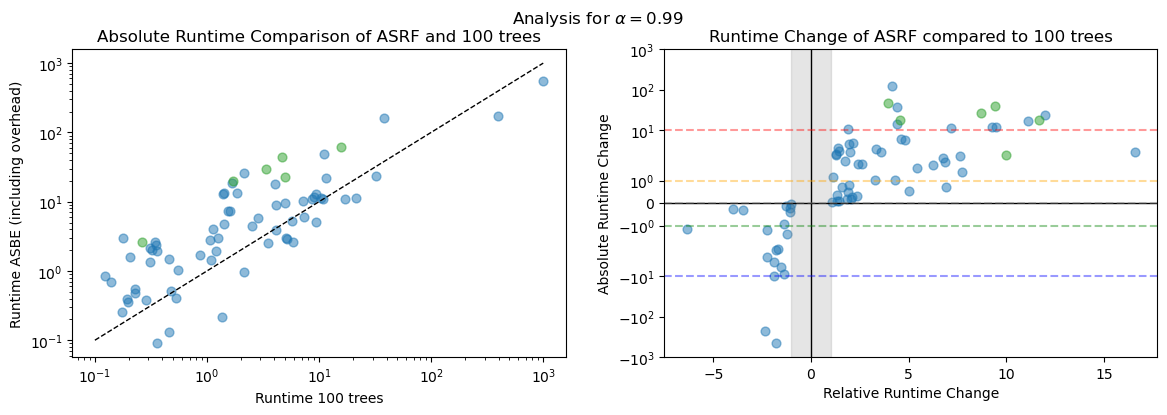

In [68]:
for idx, alpha in enumerate(alphas):
    
    fig, axs = plt.subplots(1, 2, figsize=(14, 4))
    fig.suptitle(f"Analysis for $\\alpha = {alpha}$")
    
    ax = axs[0]
    mask_we = df_results[f"ok_{alpha}"]
    mask_100 = df_results[f"ok_100"]
    
    masks = [mask_100 & mask_we, ~mask_100 & mask_we, mask_100 & ~mask_we, ~mask_100 & ~mask_we]
    colors = ["C0", "C2", "C3", "C1"]
    point_size=40
    point_alpha=0.5
    
    for mask, color in zip(masks, colors):
        ax.scatter(runtimes_baseline[mask], runtimes_asrf[mask,idx], s=point_size, color=color, alpha=point_alpha)
    ax.plot([0.1, 10**3], [0.1, 10**3], linestyle="--", color="black", linewidth=1)
    ax.set_title("Absolute Runtime Comparison of ASRF and 100 trees")
    ax.set_xlabel("Runtime 100 trees")
    ax.set_ylabel("Runtime ASBE (including overhead)")
    ax.set_xscale("log")
    ax.set_yscale("log")
    
    ax = axs[1]
    y_vals = runtimes_asrf[:,idx] - runtimes_baseline
    x_vals = runtimes_asrf[:,idx] / runtimes_baseline
    mask = x_vals < 1
    x_vals[mask] = -1 / x_vals[mask]
    
    for mask, color in zip(masks, colors):
        ax.scatter(x_vals[mask], y_vals[mask], s=point_size, color=color, alpha=point_alpha)
    ax.set_title("Runtime Change of ASRF compared to 100 trees")
    ax.set_xlabel("Relative Runtime Change")
    ax.set_ylabel("Absolute Runtime Change")
    ax.set_yscale("symlog")
    ax.set_ylim([-10**3, 10**3])
    
    ax.axvline(0, color="black", linewidth=1)
    ax.axhline(0, color="black", linewidth=1)
    ax.axhline(-10, color="blue", linestyle="--", alpha=0.4)
    ax.axhline(-1, color="green", linestyle="--", alpha=0.4)
    ax.axhline(0, color="gray", linestyle="--", alpha=0.4)
    ax.axhline(1, color="orange", linestyle="--", alpha=0.4)
    ax.axhline(10, color="red", linestyle="--", alpha=0.4)
    ax.fill_between([-1, 1], [-10**3, -10**3], [10**3, 10**3], color="gray", alpha=0.2)
    
    plt.show()

# CREATE 3D plot with (#validation instances, #trees, gap)
We would expect the gap to drop very quickly for larger datasets, because the variance for both scores should be small (those for probabilities can still be large).

In [ ]:
np.nanmean(prob_history[:10], axis=0)

In [ ]:
prob_history = prob_history_val
Y = Y_test
brier_score_per_forest_size = [np.nanmean(((Y - np.nanmean(prob_history[:t], axis=0))**2).sum(axis=1)) for t in tqdm(range(1, 500))]
brier_score_per_forest_size

In [ ]:
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(range(len(brier_score_per_forest_size)), brier_score_per_forest_size)
ax.set_ylim([0, 0.05])
plt.show()